<a href="https://colab.research.google.com/github/prayan2702/Momentum-Screen/blob/main/N750_12M_First_rank_then_filter_Sharpe_MomoCode_V4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# V3.0 : Plot the results using matplotlib and added column  More than 50% up days in the last 12 months
# added line before downloading symbol data To resolve "cannot join tz-naive with tz-aware DatetimeIndex" error
#V4.0 : Added conditional formatting to the excel output in both unfiltered and filtered excel.
# renamed column names so that column width reduced
# Volumn column now shows value in crores
"""
Created on Sun Aril 07 2024

@author: Rajesh Gavel
"""
#Date input from widget
End_date = "2024-11-28" #@param {type:"date"}

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

def getMedianVolume(data):
	return(round(data.median(),0))

def getDailyReturns(data):
	return(data.pct_change(fill_method = 'ffill')) #Modified

# change inf value to max and min value of that column
def getMaskDailyChange(data) :
 m1 = getDailyReturns(data).eq(np.inf) # for inf value
 m2 = getDailyReturns(data).eq(-np.inf) #for -inf value
 return(getDailyReturns(data).mask(m1, df[~m1].max(), axis=1).mask(m2, df[~m2].min(), axis=1).bfill(axis = 1))


def getStdev(data):
	return(np.std(getMaskDailyChange(data)*100))

def getStdRatio(data, data1):
	return((getStdev(data)/getStdev(data1)*100)) # to judge volatility 1 month against 1 year

def getAbsReturns(data):
	x = (data.iloc[-1]/data.iloc[0] - 1)*100
	return(round(x, 2))

def getVolatility(data):
	return(round(np.std(data) * np.sqrt(252) * 100, 2))

def getMonthlyPrices(data):
	grps = data.groupby([data.index.year, data.index.month])
	monthlyPrices = pd.DataFrame()
	for k in grps:
		monthlyPrices = pd.concat([monthlyPrices, k[1].tail(1)])
		# monthlyPrices = monthlyPrices.append(k[1].tail(1))
	return monthlyPrices

def getMonthlyReturns(data):
	return(data.pct_change())

def getSharpe(data):
	return(round(np.sqrt(252) * data.mean()/data.std(), 2))

def getSortino(data):
	return(np.sqrt(252) * data.mean()/data[data<0].std())

def getMaxDrawdown(data):
	cummRet = (data+1).cumprod()
	peak = cummRet.expanding(min_periods = 1).max()
	drawdown = (cummRet/peak) - 1
	return drawdown.min()

def getCalmar(data):
	return(data.mean()*252/abs(getMaxDrawdown(data)))

def getAbsMomentumVolAdjusted(absReturn, volatility):
	return(absReturn/volatility)

def getNMonthRoC(data, N):
	ret = round((data.iloc[-1]/data.iloc[-1-N] - 1) * 100, 2)
	return(ret)

def getNWeekRoC(data, N):
	ret = round((data.iloc[-1]/data.iloc[-1-N] - 1) * 100, 2)
	return(ret)

def getFIP(data):
	retPos = np.sum(data.pct_change()[1:] > 0)
	retNeg = np.sum(data.pct_change()[1:] < 0)
	return(retPos - retNeg)

def getSharpeRoC(roc, volatility):
	return(round(roc/volatility, 2))

#Beta should be calculated against relevant Index instead of Nifty50?
def getBeta(dfNifty, data12M):

	dailyReturns = getDailyReturns(pd.concat([dfNifty, data12M], axis = 1))[1:]

	var = np.var(dailyReturns['Nifty']) #Modified

	cov = dailyReturns.cov()

	cols = cov.columns[1:]

	beta = []

	for k in cols:
		beta.append(round(cov.loc[k, 'Nifty']/var, 2))

	return beta


Mounted at /content/drive


Universe:  N750
Lookback: 12 Months
Ranking: ['avgSharpe']
Filter: True


Start Date:  2000-01-01 00:00:00
12M Date:  2023-11-28 00:00:00
9M Date:  2024-02-28 00:00:00
6M Date:  2024-05-28 00:00:00
3M Date:  2024-08-28 00:00:00
1M Date: 2024-10-28 00:00:00
End Date:  2024-11-28 00:00:00


0,

50,

100,

150,

200,

250,

300,

350,

400,

450,

500,

550,

600,

650,

700,

Done with downloading DATA 

Got data slices for each timeframe 

Done calculating ROCs 

Done calculating Volatility 

Done calculating Sharpe  


 Writing unfiltered data to file. Shape in next line 

(750, 21)

Excel unfiltered file updated with formatting

Applied Filters 


 Writing data to file 


 Successfully Done 


Excel filtered file updated with formatting and summary added.

Strategy: Buy top 30, hold till rank 75


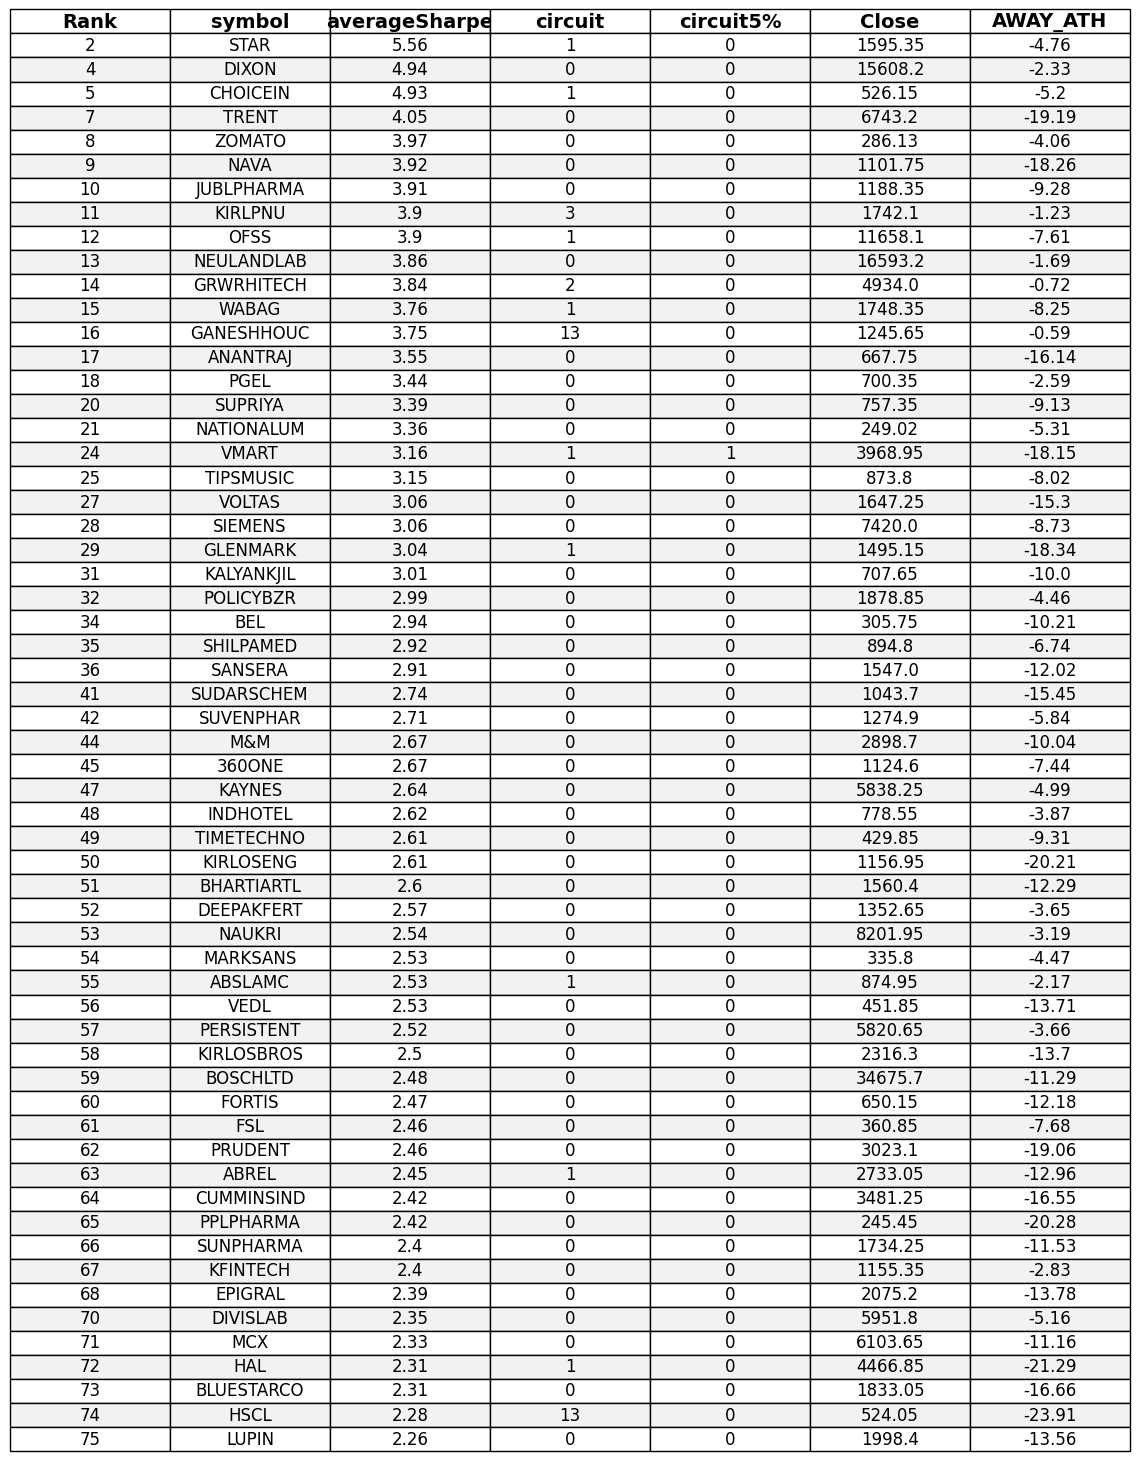

In [ ]:
import pandas as pd
import numpy as np
import time
from scipy.stats import zscore
from datetime import datetime
import yfinance as yf
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from matplotlib.table import Table

#To suppress future warnings about using ffill method in pct_change()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.max_rows', 3000)
pd.set_option('display.width', 1000)

universe = ['Nifty50', 'Nifty100', 'Nifty200', 'Nifty250', 'Nifty500', 'N750', 'AllNSE']

# Pick universe, lookback
U = universe[5] #Selecting N750 Stocks

# Two-factor ranking
# First sort by Average sharpe of 12M, 9M, 6M and 3M and get the rank
# Next sort by deducting 1M ROC from 12M ROC to avoid recency bias and get the rank
# Add the above 2 ranks and sort by ascending ranks
#rm = ['sharpe12MRoC', 'FIP12M']
#rm = ['averageSharpe', '12MROCMinus1MROC']
rm = ['avgSharpe']

# Apply various filters
applyFilter = True

print('Universe: ', U)
print('Lookback: 12 Months')
print('Ranking:', rm)
print('Filter:', str(applyFilter))
print("\n")

# Dates: shift by 1 month at every rebalance
dates = dict()
# Don't change date below (20 year from today's date)
dates['startDate'] = datetime.strptime('2000-01-01', '%Y-%m-%d')
# change the end date below to today
dates['endDate'] = datetime.strptime(End_date , '%Y-%m-%d')
# calculating dates 1M back, 3M back, 6M back, 9M back and 12M back
dates['date1M'] = dates['endDate'] - relativedelta(months=+1)
dates['date3M'] = dates['endDate'] - relativedelta(months=+3)
dates['date6M'] = dates['endDate'] - relativedelta(months=+6)
dates['date9M'] = dates['endDate'] - relativedelta(months=+9)
dates['date12M'] = dates['endDate'] - relativedelta(months=+12)


#Print the dates
print('Start Date: ', dates['startDate'])
print('12M Date: ', dates['date12M'])
print('9M Date: ', dates['date9M'])
print('6M Date: ', dates['date6M'])
print('3M Date: ', dates['date3M'])
print('1M Date:', dates['date1M'])
print('End Date: ', dates['endDate'])
print('\n')

# Read index file
if U == 'Nifty50':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty50list.csv')
elif U == 'Nifty100':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty100list.csv')
elif U == 'Nifty200':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty200list.csv')
elif U == 'Nifty250':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_niftysmallcap250list.csv')
elif U == 'Nifty500':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_nifty500list.csv')
elif U == 'N750':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/ind_niftytotalmarket_list.csv')
elif U == 'AllNSE':
    df = pd.read_csv('/content/drive/MyDrive/RAJ MOMN PORTFOLIO/UploadIndexCSV/NSE_EQ_ALL.csv')

# Drop unnecessary columns
df.drop(['Series', 'ISIN Code', 'Industry'], axis = 1, inplace = True)

# Create Yahoo symbol
df['Yahoo_Symbol'] = df.Symbol + '.NS'
df = df.set_index('Yahoo_Symbol')
symbol = list(df.index)


# Get yahoofinance data in chunks of 50
CHUNK = 50
close = []
high = [] #(Additional added condition)
volume = []
for k in range(0, len(symbol), CHUNK):
    print(k, end = ',', flush = True)
    print("\n")
    _symlist = symbol[k:k+CHUNK]
    _x = yf.download(_symlist, start = dates['startDate'], progress = False)
    _x = _x.tz_localize(None)    # To resolve "cannot join tz-naive with tz-aware DatetimeIndex" error
    close = _x['Close'] if len(close) == 0 else pd.concat([close, _x['Close']], axis = 1)
    high = _x['High'] if len(high) == 0 else pd.concat([high, _x['High']], axis = 1) #(Additional added condition)
    volume = _x['Close']*_x['Volume'] if len(volume) == 0 else pd.concat([volume, (_x['Close']*_x['Volume'])], axis = 1)
    time.sleep(.5)

print("Done with downloading DATA \n")
# Keep the data within the date range for 1 year and 10year(for ATH) data
data20Y = close[:dates['endDate']].copy()
volume20Y = volume[:dates['endDate']].copy() #(Additional added condition)
high20Y = high[:dates['endDate']].copy() #(Additional added condition)
volume12M = volume20Y[dates['date12M']:].copy() # Gets last 12M volume


# At least 12 months of trading is required
#data12M.dropna(axis = 1, inplace = True)
#volume12M.dropna(axis = 1, inplace = True)
data12M = data20Y[dates['date12M']:].copy() # Gets last 12M data
data9M = data20Y[dates['date9M']:].copy() # Gets last 9M data
data6M = data20Y[dates['date6M']:].copy() # Gets last 6M data
data3M = data20Y[dates['date3M']:].copy() # Gets last 3M data
data1M = data20Y[dates['date1M']:].copy() # Gets last 1M data

print("Got data slices for each timeframe \n")

# Stats DataFrame
dfStats = pd.DataFrame()

# Rate of change
dfStats['roc1M'] = getAbsReturns(data1M)
dfStats['roc3M'] = getAbsReturns(data3M)
dfStats['roc6M'] = getAbsReturns(data6M)
dfStats['roc9M'] = getAbsReturns(data9M)
dfStats['roc12M'] = getAbsReturns(data12M)


print("Done calculating ROCs \n")


# Volatility
dfStats['vol3M'] = getVolatility(getDailyReturns(data3M))
dfStats['vol6M'] = getVolatility(getDailyReturns(data6M))
dfStats['vol9M'] = getVolatility(getDailyReturns(data9M))
dfStats['vol12M'] = getVolatility(getDailyReturns(data12M))

print("Done calculating Volatility \n")
dfStats['shrp3M'] = getSharpeRoC(dfStats['roc3M'], dfStats['vol3M'])
dfStats['shrp6M'] = getSharpeRoC(dfStats['roc6M'], dfStats['vol6M'])
dfStats['shrp9M'] = getSharpeRoC(dfStats['roc9M'], dfStats['vol9M'])
dfStats['shrp12M'] = getSharpeRoC(dfStats['roc12M'], dfStats['vol12M'])


#MAIN FACTORS for ranking stocks. we are using 2 factors
dfStats['avgSharpe'] = dfStats["shrp12M"] #1st Factor
#dfStats['12MROCMinus1MROC'] = dfStats["roc12M"] - dfStats["roc1M"] #2nd Factor

print("Done calculating Sharpe  \n")

dfStats['volm_cr'] = getMedianVolume(volume12M)/1e7


# Calculate No. of circuits in one year (Additional added condition)
dataDaily_pct = round(getDailyReturns(data12M)*100,2)
dfStats['circuit'] = (dataDaily_pct == 4.99).sum() + (dataDaily_pct == 5.00).sum() + (dataDaily_pct == 9.99).sum() + (dataDaily_pct == 10.00).sum() + (dataDaily_pct == 19.99).sum() + (dataDaily_pct == 20.00).sum() + (dataDaily_pct == -4.99).sum() + (dataDaily_pct == -5.00).sum() + (dataDaily_pct == -9.99).sum() + (dataDaily_pct == -10.00).sum() + (dataDaily_pct == -19.99).sum() + (dataDaily_pct == -20.00).sum()

#Calculate No. of 5% circuit in last 3-month for filter
dataDaily_pct5 = round(getDailyReturns(data3M)*100,2)
dfStats['circuit5'] = (dataDaily_pct5 == 4.99).sum() + (dataDaily_pct5 == 5.00).sum() + (dataDaily_pct5 == -4.99).sum() + (dataDaily_pct5 == -5.00).sum()

# close and ema
dfStats['Close'] = round(data12M.iloc[-1], 2)

#Calculate ATH and Away from ATH% (Additional added condition)
dfStats['ATH'] = high20Y.max()
dfStats['AWAY_ATH'] = round((dfStats['Close']/dfStats['ATH']-1)*100,2) #Calculate %away from ALL TIME HIGH


#fileName = './OutputMonthly/RAW_' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.csv'
#data12M.to_csv(fileName, index = False, float_format = "%.2f")
data12M_Temp = data12M.fillna(0)     #(Modified as it inflated beta)
#dfStats['dma100d'] = round(data12M_Temp.rolling(window=100).mean().iloc[-1], 2)
dfStats['dma200d'] = round(data12M_Temp.rolling(window=200).mean().iloc[-1], 2)    #Modified

# # More than 50% up days in the last 12 months
# up_days = (data12M.pct_change() > 0).sum()
# dfStats['up_days_pct'] = up_days / len(data12M) * 100

# Get Nifty data (Additional added condition)
# dfNifty = yf.download("^NSEI", start = dates['date12M'], end=dates['endDate'], progress = False)['Close']  #(Added enddate)
# dfNifty = dfNifty.to_frame().rename(columns = {'Close':'Nifty'})

# # Get stock beta (Additional added condition)
# dfStats['Beta'] = getBeta(dfNifty, data12M)

#PRINT OUT ALL THE STOCKS DATA without any filters
#print("\n Writing unfiltered data to file. Shape in next line \n")
#print(dfStats.shape)
#fileName = '/content/Unfiltered' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.csv'
#unfiltered = dfStats.reset_index().rename(columns = {'index':'symbol'})
#unfiltered.to_csv(fileName, index = False, float_format = "%.2f")



#Ignore(drop) Top 10 percent Highest Beta stock against Nifty from the selected universe (Additional added condition)
#dfStats = dfStats.sort_values(by = ["Beta"], axis = 0, ascending=False)
#dfStats = dfStats.tail(len(dfStats) - round(len(dfStats)*0.1))     #drop top 10% highest beta

#FIRST, sort by Sharpe for 12M
unfiltered = dfStats.sort_values(rm[0], ascending = False).reset_index().rename(columns = {'index':'symbol'})
# Assign rank
unfiltered['Rank'] = range(1, unfiltered.shape[0] + 1)
unfiltered = unfiltered.sort_values('Rank', ascending = True)

# shift column 'Rank' to first position. First remove that column from list
first_column = unfiltered.pop('Rank')

# insert column using insert(position,column_name, first_column) function
unfiltered.insert(0, 'Rank', first_column)

# remove suffix:-'.NS' from symbol column
unfiltered.loc[:,('Ticker')] = unfiltered.loc[:,('Ticker')].str.replace('.NS', '')

#PRINT OUT ALL THE STOCKS DATA without any filters
print("\n Writing unfiltered data to file. Shape in next line \n")
print(dfStats.shape)
fileName = '/content/Unfiltered' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.xlsx'
unfiltered.to_excel(fileName, index = False, float_format = "%.2f")

# ****************************************************************
# Format cells and save back as excel
import openpyxl
from openpyxl.styles import PatternFill
from openpyxl.styles import Font
from openpyxl.styles import Alignment
from openpyxl.styles.borders import Border, Side

# Open the written file using openpyxl
wb = openpyxl.load_workbook(fileName)
ws = wb.active

# Extract headers again if not already in scope
headers = [cell.value for cell in ws[1]]  # Assuming the first row contains the column names

# Ticker Column Index (Assuming 'Ticker' is the first column)
ticker_idx = headers.index('Ticker') + 1  # Adjust based on the actual position if not the first column

#Add Borders to All Cells
thin_border = Border(left=Side(style="thin"), right=Side(style="thin"), top=Side(style="thin"), bottom=Side(style="thin"))

for row in ws.iter_rows(min_row=1, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    for cell in row:
        cell.border = thin_border
        cell.alignment = Alignment(horizontal="center", vertical="center")

# Freeze the top row
ws.freeze_panes = 'A2'  # This will freeze the top row (row 1)

# Define the bold font style
bold_font = Font(bold=True)


# Format headers
header_fill = PatternFill(start_color="00008B", end_color="00008B", fill_type="solid")  #Dark blue
header_font = Font(bold=True, color="FFFFFF")  # White text
header_alignment = Alignment(horizontal="center", vertical="center")

for col in range(1, ws.max_column + 1):
    cell = ws.cell(row=1, column=col)
    cell.fill = header_fill
    cell.font = header_font
    cell.alignment = header_alignment

#Automatically adjust column widths based on content
for col in ws.columns:
    max_length = 0
    column = col[0].column  # Get the column letter
    for cell in col:
        if cell.value:
            max_length = max(max_length, len(str(cell.value)))
    adjusted_width = max_length + 2
    ws.column_dimensions[cell.column_letter].width = adjusted_width

# Define cell color for cells that do not meet the filter conditions
no_condition_fill = PatternFill(start_color="d6b4fc", end_color="d6b4fc", fill_type="solid")

# Get the headers to find column indexes by name
headers = [cell.value for cell in ws[1]]  # Assuming the first row contains the column names

# Find the index of specific columns
volm_cr_idx = headers.index('volm_cr') + 1  # Adding 1 to convert to 1-based index
close_idx = headers.index('Close') + 1
dma200d_idx = headers.index('dma200d') + 1
away_ath_idx = headers.index('AWAY_ATH') + 1
roc12M_idx = headers.index('roc12M') + 1
circuit_idx = headers.index('circuit') + 1
roc1M_idx = headers.index('roc1M') + 1
circuit5_idx= headers.index('circuit5') + 1

# Apply the conditional formatting: highlight cells that do not satisfy filters
for row in range(2, ws.max_row + 1):  # Start from row 2 to skip headers
    # Get the values from the relevant columns
    volume = ws.cell(row=row, column=volm_cr_idx).value
    close = ws.cell(row=row, column=close_idx).value
    dma200d = ws.cell(row=row, column=dma200d_idx).value
    away_ath = ws.cell(row=row, column=away_ath_idx).value
    roc12M = ws.cell(row=row, column=roc12M_idx).value
    circuit = ws.cell(row=row, column=circuit_idx).value
    roc1M = ws.cell(row=row, column=roc1M_idx).value
    circuit5 = ws.cell(row=row, column=circuit5_idx).value

     # Flag for any condition failure
    condition_failed = False

    # Apply red color and bold font if the condition is not satisfied
    if volume is not None and volume < 1:
        ws.cell(row=row, column=volm_cr_idx).fill = no_condition_fill
        ws.cell(row=row, column=volm_cr_idx).font = bold_font
        condition_failed = True
    if close is not None and close <= dma200d:
        ws.cell(row=row, column=close_idx).fill = no_condition_fill
        ws.cell(row=row, column=close_idx).font = bold_font
        condition_failed = True
    if away_ath is not None and away_ath <= -25:
        ws.cell(row=row, column=away_ath_idx).fill = no_condition_fill
        ws.cell(row=row, column=away_ath_idx).font = bold_font
        condition_failed = True
    if roc12M is not None and roc12M <= 6.5:
        ws.cell(row=row, column=roc12M_idx).fill = no_condition_fill
        ws.cell(row=row, column=roc12M_idx).font = bold_font
        condition_failed = True
    if circuit is not None and circuit >= 20:
        ws.cell(row=row, column=circuit_idx).fill = no_condition_fill
        ws.cell(row=row, column=circuit_idx).font = bold_font
        condition_failed = True
    if roc1M is not None and roc12M is not None and roc12M != 0:  # Check for None and division by zero
        if roc1M / roc12M * 100 >= 50:
            ws.cell(row=row, column=roc1M_idx).fill = no_condition_fill
            ws.cell(row=row, column=roc1M_idx).font = bold_font
            condition_failed = True
    if close is not None and close <= 30:
        ws.cell(row=row, column=close_idx).fill = no_condition_fill
        ws.cell(row=row, column=close_idx).font = bold_font
        condition_failed = True
    if circuit5 is not None and circuit5 > 10:
        ws.cell(row=row, column=circuit5_idx).fill = no_condition_fill
        ws.cell(row=row, column=circuit5_idx).font = bold_font
        condition_failed = True
    if roc12M is not None and roc12M > 1000:
        ws.cell(row=row, column=roc12M_idx).fill = no_condition_fill
        ws.cell(row=row, column=roc12M_idx).font = bold_font
        condition_failed = True

    # Highlight the Ticker if any condition failed
    if condition_failed:
        ticker_cell = ws.cell(row=row, column=ticker_idx)
        ticker_cell.fill = no_condition_fill
        # ticker_cell.font = bold_font

# Identify the column for "AWAY_ATH"
# Assuming 'AWAY_ATH' is the header and the column index is found
column_index = None
for col in range(1, ws.max_column + 1):
    if ws.cell(row=1, column=col).value == "AWAY_ATH":  # Search for header
        column_index = col
        break

if column_index is not None:
    # Loop through the cells in the "AWAY_ATH" column and append '%'
    for row in range(2, ws.max_row + 1):  # Starting from row 2 to skip header
        cell = ws.cell(row=row, column=column_index)
        if cell.value is not None and isinstance(cell.value, (int, float)):  # Check if it's a number
            cell.value = str(cell.value) + '%'  # Append the % symbol as a string


# Define the light green color fill
light_green_fill = PatternFill(start_color="90EE90", end_color="90EE90", fill_type="solid")

# Identify the column for "Rank"
column_index = None
for col in range(1, ws.max_column + 1):
    if ws.cell(row=1, column=col).value == "Rank":  # Search for header
        column_index = col
        break

if column_index is not None:
    # Loop through the cells in the "Rank" column
    for row in range(2, ws.max_row + 1):  # Starting from row 2 to skip header
        cell = ws.cell(row=row, column=column_index)
        if cell.value is not None and isinstance(cell.value, (int, float)) and cell.value <= 75:
            # Apply the light green color fill if rank is 75 or less
            cell.fill = light_green_fill


# Save the modified Excel file with highlighted cells
wb.save(fileName)

print("\nExcel unfiltered file updated with formatting\n")

# *****************************************************************


# Apply filters: e.g. RoC12M > FD rate
cond1 = unfiltered['volm_cr'] > 1 #volume filter greater than 1 crore
#cond2 = unfiltered['Close'] > unfiltered['dma100d'] # above 100-day DMA
cond3 = unfiltered['Close'] > unfiltered['dma200d'] # above 200-day DMA
cond4 = unfiltered['roc12M'] > 6.5 #12M ROC above G-sec rate
cond5 = unfiltered['circuit'] < 20 #No. of circuit less than 20 (Additional added condition)
cond6 = unfiltered['AWAY_ATH'] > -25 #Away from All Time High within 25%
cond7 = unfiltered['roc12M'] < 1000  #12M return less than 10x and atleast 12M trading required
cond8 = unfiltered['roc1M']/unfiltered['roc12M']*100 < 50   #1m ROC/12m ROC < 50%
cond9 = unfiltered['Close'] > 30  #stock pricce above 30
cond10 = unfiltered['circuit5'] <= 10   #No. of 5% circuit in last 3 month should be less than 6 (newly added)
#cond11 = unfiltered['up_days_pct'] > 50

cond = cond1 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9 & cond10

if applyFilter == True:
    filtered = unfiltered[cond]
elif applyFilter == False:
    filtered = unfiltered


print("Applied Filters \n")

#FIRST, sort by Sharpe for 12M
output = filtered.sort_values(rm[0], ascending = False)
# Assign rank
#output['Rank1'] = range(1, output.shape[0] + 1)

#SECOND, sort by (12M ROC - 1M ROC)
#output = output.sort_values(rm[1], ascending = False)
# Assign rank
#output['Rank2'] = range(1, output.shape[0] + 1)

#Now, combine both the ranks and sort with ranks sorted in ascending order
#output['FinalRank'] = output['Rank1'] + output['Rank2']
#output['FinalRank'] = output['Rank1']
output = output.sort_values('Rank', ascending = True)

# shift column 'Rank' to first position. First remove that column from list
first_column = output.pop('Rank')

# insert column using insert(position,column_name, first_column) function
output.insert(0, 'Rank', first_column)

print("\n Writing data to file \n")

fileName = '/content/Filtered' + dates['endDate'].strftime('%Y-%m-%d') + '_' + U + '_' + '12M' + '_lookback' + '.xlsx'
output.to_excel(fileName, index = False, float_format = "%.2f")
print("\n Successfully Done \n")


# ****************************************************************
# # Format cells and save back as excel
# # Open the written file using openpyxl

import openpyxl
from openpyxl.styles import Border, Side, Alignment, Font, PatternFill

# Format cells and save back as excel
# Open the written file using openpyxl
wb = openpyxl.load_workbook(fileName)
ws = wb.active

# Add Borders to All Cells
thin_border = Border(left=Side(style="thin"), right=Side(style="thin"), top=Side(style="thin"), bottom=Side(style="thin"))

for row in ws.iter_rows(min_row=1, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
    for cell in row:
        cell.border = thin_border
        cell.alignment = Alignment(horizontal="center", vertical="center")

# Freeze the top row
ws.freeze_panes = 'A2'  # This will freeze the top row (row 1)

# Format headers
header_fill = PatternFill(start_color="00008B", end_color="00008B", fill_type="solid")  # Dark blue
header_font = Font(bold=True, color="FFFFFF")  # White text
header_alignment = Alignment(horizontal="center", vertical="center")

for col in range(1, ws.max_column + 1):
    cell = ws.cell(row=1, column=col)
    cell.fill = header_fill
    cell.font = header_font
    cell.alignment = header_alignment

# Automatically adjust column widths based on content
for col in ws.columns:
    max_length = 0
    for cell in col:
        if cell.value:
            max_length = max(max_length, len(str(cell.value)))
    adjusted_width = max_length + 2
    ws.column_dimensions[cell.column_letter].width = adjusted_width

# Append '%' to "AWAY_ATH" column values
column_index = None
for col in range(1, ws.max_column + 1):
    if ws.cell(row=1, column=col).value == "AWAY_ATH":  # Search for header
        column_index = col
        break

if column_index is not None:
    for row in range(2, ws.max_row + 1):  # Starting from row 2 to skip header
        cell = ws.cell(row=row, column=column_index)
        if cell.value is not None and isinstance(cell.value, (int, float)):  # Check if it's a number
            cell.value = str(cell.value) + '%'  # Append the % symbol as a string

# Highlight "Rank" column cells where value <= 75 with light green
light_green_fill = PatternFill(start_color="90EE90", end_color="90EE90", fill_type="solid")
column_index = None
for col in range(1, ws.max_column + 1):
    if ws.cell(row=1, column=col).value == "Rank":  # Search for header
        column_index = col
        break

rank_75_count = 0  # Counter for rank <= 75
if column_index is not None:
    for row in range(2, ws.max_row + 1):  # Starting from row 2 to skip header
        cell = ws.cell(row=row, column=column_index)
        if cell.value is not None and isinstance(cell.value, (int, float)) and cell.value <= 75:
            # Apply the light green color fill if rank is 75 or less
            cell.fill = light_green_fill
            rank_75_count += 1

# Calculate summary values
total_filtered_stocks = ws.max_row - 1  # Exclude header row
rank_75_summary_text = f"Number of Stocks within 75 Rank :  {rank_75_count}"
total_summary_text = f"Total Filtered Stocks:  {total_filtered_stocks}"

# Add summary to the sheet
ws.append([])  # Add an empty row
ws.append(["Summary"])  # Add "Summary" heading
summary_row_start = ws.max_row
ws.append([total_summary_text])  # Total filtered stocks
ws.append([rank_75_summary_text])  # Stocks with rank <= 75

# Apply bold font to the summary section
for row in ws.iter_rows(min_row=summary_row_start, max_row=ws.max_row, min_col=1, max_col=1):
    for cell in row:
        cell.font = Font(bold=True)

# Save the modified Excel file
wb.save(fileName)

print("\nExcel filtered file updated with formatting and summary added.\n")
# # #********************************************************************************

print("Strategy: Buy top 30, hold till rank 75")


# Sort by final rank and get only the rows where Rank <= 75
df_sorted = output.sort_values('Rank')
df_top_75 = df_sorted[df_sorted['Rank'] <= 75]  # Filter rows with Rank <= 75

# Prepare table data
tbl_data = []
for i, row in df_top_75.iterrows():
    tbl_data.append([row['Rank'], row['Ticker'],
                     row['avgSharpe'], row['circuit'],
                     row['circuit5'], row['Close'],
                     row['AWAY_ATH']])

# Plot the results using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

# Create a table with top 75 stocks
col_labels = ['Rank', 'symbol', 'averageSharpe', 'circuit', 'circuit5%', 'Close', 'AWAY_ATH']
table = ax.table(cellText=tbl_data, colLabels=col_labels, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Formatting for readability
for i, cell in table.get_celld().items():
    if i[0] == 0:  # First row (header)
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')
    else:
        if i[0] % 2 == 0:  # Alternate row coloring
            cell.set_facecolor('#f2f2f2')  # Light gray
        else:
            cell.set_facecolor('white')

# Adjust layout
plt.subplots_adjust(left=0.1, top=0.85)  # Adjust top parameter for title position
#plt.title('Top 75 Stocks Momentum Ranking', fontsize=18, y=1.05)  # y parameter for title position
plt.show()